In [12]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.preprocessing import MinMaxScaler
!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ffdb04990cff4734927a1b486435b4c8 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='vzyOYCEeCsQ8xicz0dp1mNkSLBFBqROZSfEDNbryPyya',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ffdb04990cff4734927a1b486435b4c8.get_object(Bucket='challenge1-donotdelete-pr-ypjfeu5u3zbql2',Key='heart_failure_clinical_records_dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )



# Explore Data

In [13]:
data = pd.read_csv(body)
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [14]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## Explore Numeric Columns

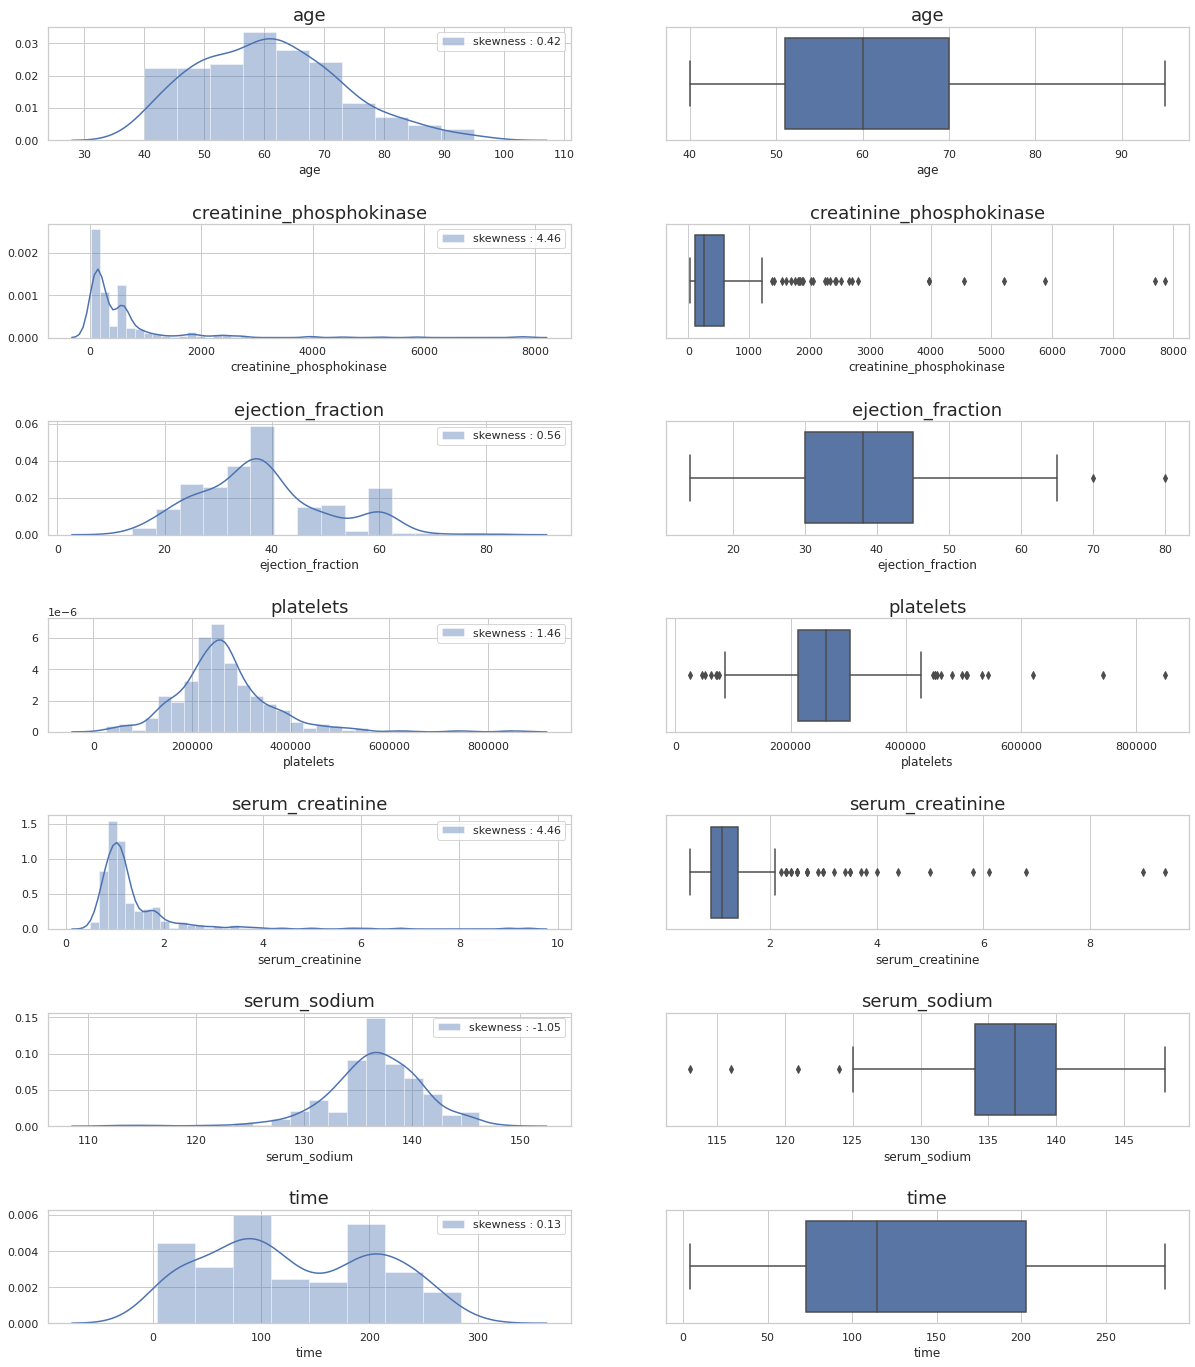

In [15]:
num_columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
fig, ax =plt.subplots(7,2, figsize=(18,20))
fig.tight_layout(pad=5.0)


for i, col in enumerate(num_columns):
    sns.distplot(ax = ax[i,0], a = data[col].dropna(), label = 'skewness : %.2f'%(data[col].skew()))
    ax[i,0].set_title(col, fontsize = 18)
    ax[i,0].legend(loc = 'best')
    
    sns.boxplot(ax = ax[i, 1], x = data[col].dropna())
    ax[i, 1].set_title(col, fontsize = 18)
plt.show()

In [16]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## Explore Category Columns

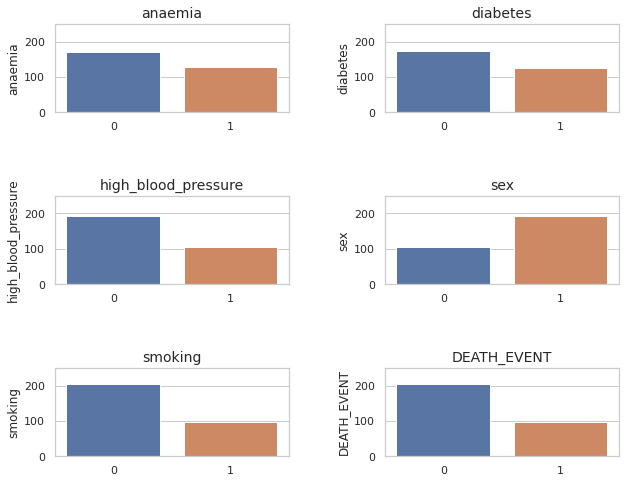

In [17]:
cat_columns = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']
fig, ax = plt.subplots(3,2, figsize = (10, 8))
fig.tight_layout(pad = 5.0)

for ax, col in zip(ax.flatten(), cat_columns):
    index = data[col].fillna('NaN').value_counts().index
    counts = data[col].fillna('NaN').value_counts()
    sns.barplot(ax = ax, x = index, y = counts)
    ax.set_title(col, fontsize = 14)
    ax.set_ylim(0, 250)

## Heatmap (Correlations)

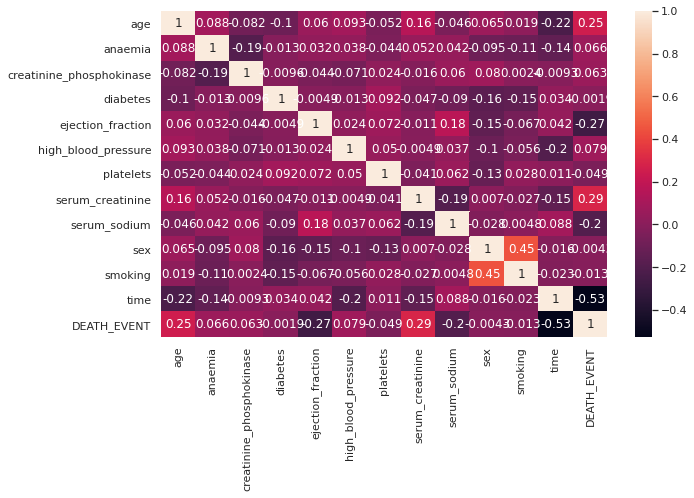

In [18]:
heatmapdata = data
cormat = heatmapdata.corr()
fig, ax = plt.subplots(figsize = (10,6))
sns.heatmap(ax = ax, data = cormat, annot = True)
plt.show()

# Preprocessing Data

## Mengatasi skewness dan data outlier

In [19]:
# mengatasi skewness data, dengan transformasi log
data['creatinine_phosphokinase'] = np.log1p(data['creatinine_phosphokinase'])
data['platelets'] = np.log1p(data['platelets'])
data['serum_creatinine'] = np.log1p(data['serum_creatinine'])
data['serum_sodium'] = np.log1p(data['serum_sodium'])

# mengatasi outlier data dengan mengganti data outlier (nilai yang diluar dari batas maksimum dan minimum pada boxplot) dengan nilai median
for i, col in enumerate(num_columns):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3-q1
    data.loc[((data[col] < (q1 - 1.5 * iqr)) | (data[col] > (q3+1.5*iqr))), col] = data[col].median()


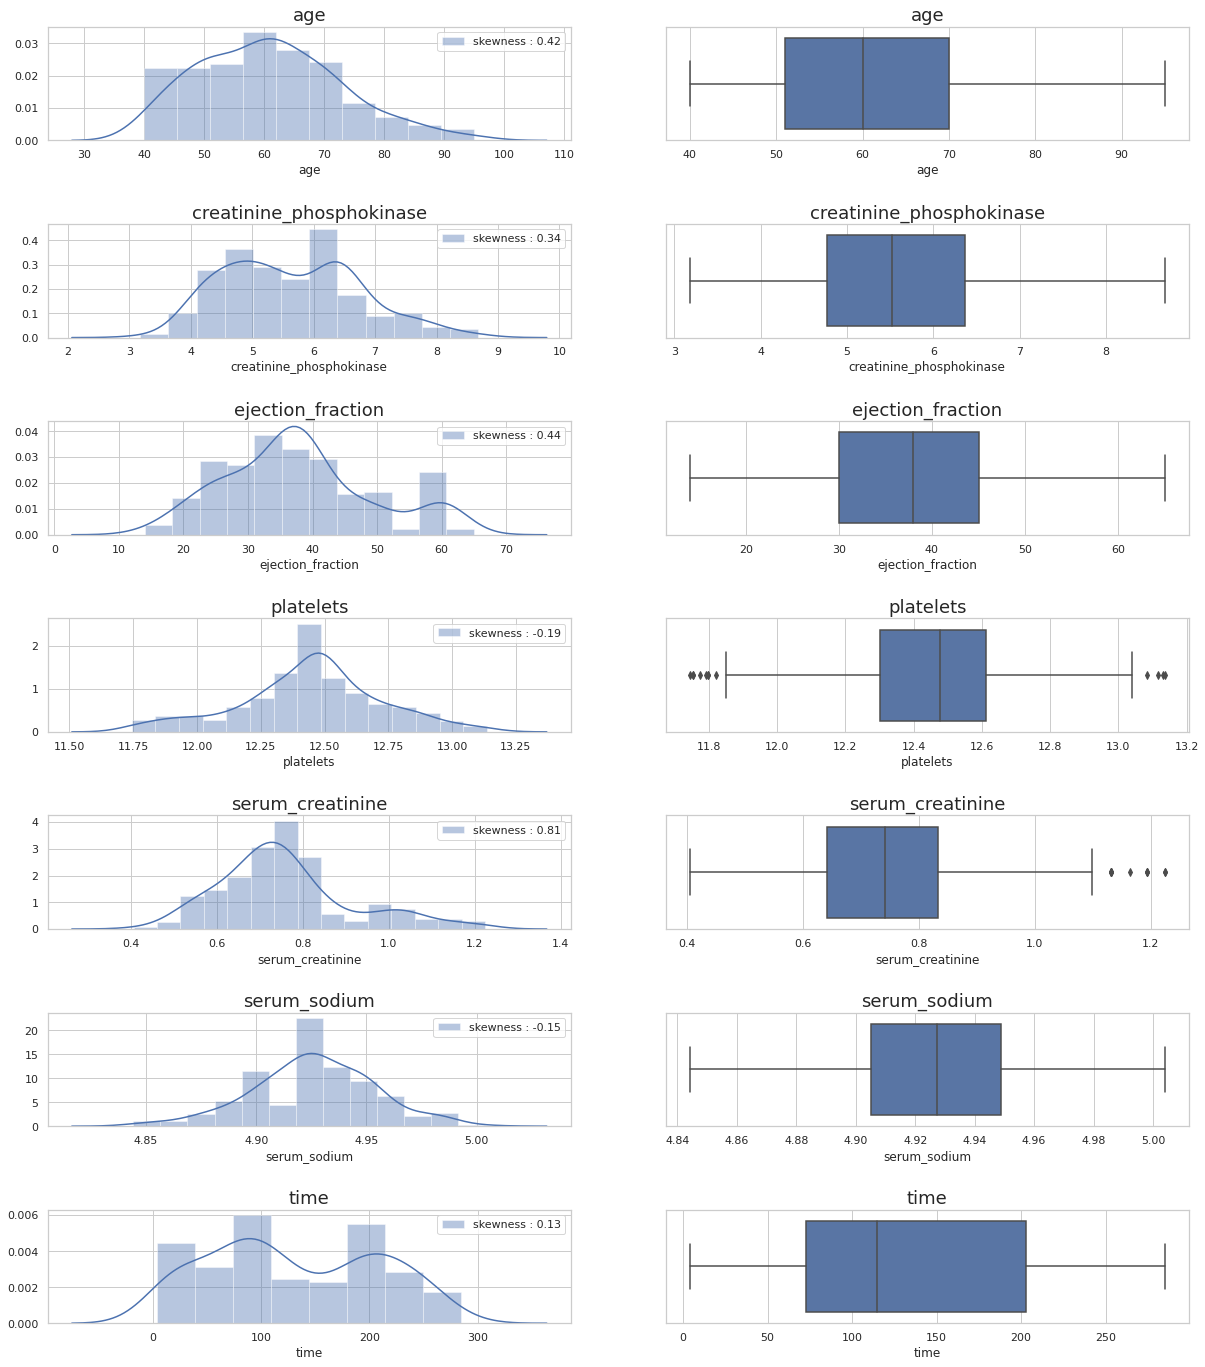

In [20]:
fig, ax =plt.subplots(7,2, figsize=(18,20))
fig.tight_layout(pad=5.0)
for i, n in enumerate(num_columns):
    sns.distplot(ax = ax[i,0], a = data[n].dropna(), label = 'skewness : %.2f'%(data[n].skew()))
    ax[i,0].set_title(n, fontsize = 18)
    ax[i,0].legend(loc = 'best')
    
    sns.boxplot(ax = ax[i, 1], x = data[n].dropna())
    ax[i, 1].set_title(n, fontsize = 18)
plt.show()

## Normalisasi Data Numeric

In [21]:
sc = MinMaxScaler()

sc.fit(data[num_columns])
data[num_columns] = sc.transform(data[num_columns])

In [22]:
data[num_columns].head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0,0.636364,0.579838,0.117647,0.533998,0.805618,0.194106,0.000000
1,0.272727,0.426663,0.470588,0.529533,0.411179,0.474425,0.007117
2,0.454545,0.329418,0.117647,0.180512,0.522350,0.146141,0.010676
3,0.181818,0.279991,0.117647,0.366911,0.805618,0.519949,0.010676
4,0.454545,0.345953,0.117647,0.685000,0.411179,0.519949,0.014235


## Feature Selection dan SMOTE (Synthetic Minority Over-sampling Technique)

In [23]:
X = data.iloc[:, 0:12]
y = data.iloc[:, -1]
# Dikarenakan nilai variable target tidak imbang (nilai 0 ada 203 baris data, sedangkan nilai 1 hanya 96 baris data), maka dilakukan metode SMOTE untuk menyeimbangkan nilai tersebut
X_smote, y_smote = SMOTE().fit_sample(X,y)
print('Hasil perbandingan nilai pada variable target setelah dilakukan metode SMOTE \n', y_smote.value_counts())

Hasil perbandingan nilai pada variable target setelah dilakukan metode SMOTE 
 1    203
0    203
Name: DEATH_EVENT, dtype: int64


## Partisi Data ( data latih = 80%, data uji = 20% )

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 0)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (324, 12)
y_train shape : (324,)
X_test shape : (82, 12)
y_test shape : (82,)


## Evaluasi Model

### KNN

In [14]:
clf = KNeighborsClassifier()
parameters = [{'n_neighbors' : [3, 5, 7, 9], 
               'weights' : ['uniform', 'distance'],
                'leaf_size' : list(range(1,50,5)), 
               'p' : [1, 2],
               'metric' : ['manhattan', 'euclidean', 'minkowski']
               }]

grid_search = GridSearchCV(estimator = clf, param_grid = parameters, scoring = 'accuracy', cv =10, n_jobs = -1 )

grid_search.fit(X_train, y_train)
print('Parameter terbaik : ', grid_search.best_params_)
print('Rata-rata akurasi : ', grid_search.best_score_)

Parameter terbaik :  {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Rata-rata akurasi :  0.7961174242424243


### XGBoost

In [15]:
clf = XGBClassifier()


parameters = [{'max_depth' : [3, 4, 5], 
               'learning_rate' : [0.1, 0.001, 0.0001], 
               'n_estimators' : [100, 150] 
              }]

grid_search = GridSearchCV(estimator = clf, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)
print('Parameter terbaik : ', grid_search.best_params_)
print('Rata-rata akurasi : ', grid_search.best_score_)

Parameter terbaik :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Rata-rata akurasi :  0.8707386363636364


### Random Forest

In [16]:
clf = RandomForestClassifier()
parameters = [{'n_estimators' : [20, 50, 100], 
               'criterion' : ['entropy', 'gini'], 
               'verbose' : [0, 0.5, 1]
              }]

grid_search = GridSearchCV(estimator = clf, param_grid = parameters, scoring = 'accuracy', cv =10, n_jobs = -1)
grid_search.fit(X_train, y_train)
print('Parameter terbaik : ', grid_search.best_params_)
print('Rata-rata akurasi : ', grid_search.best_score_)

Parameter terbaik :  {'criterion': 'gini', 'n_estimators': 50, 'verbose': 0.5}
Rata-rata akurasi :  0.8831439393939394


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


## Pengujian
Menggunakan metode Random Forest dengan parameter = {'criterion': 'gini', 'n_estimators': 50, 'verbose': 0.5}

In [17]:
clf = RandomForestClassifier(criterion = 'gini', n_estimators = 50, verbose = 0.5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0])

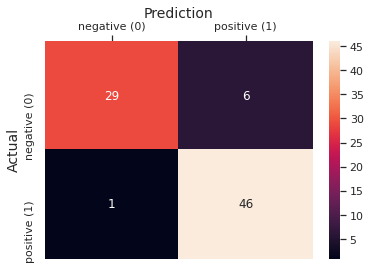

In [18]:
fig, ax = plt.subplots(figsize = (6,4))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'positive (1)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'positive (1)'])
plt.show()

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

accuracy = (tp+tn)/(tp+tn+fp+fn)
recall = tp/(tp+fn)
precission = tp/(tp+fp)

print('Accuracy : ', round(accuracy, 4))
print('Recall : ', round(recall, 4))
print('Precission :', round(precission, 4))

Accuracy :  0.9146
Recall :  0.9787
Precission : 0.8846
